# A Simple Quantum Classifier

_This notebook explores the creation and use of a model in **PennyLane and PyTorch**_.

**By:** Jacob Cybulski ([website](https://jacobcybulski.com/))<br>
**Date:** 1 October 2024<br>
**Updates:** 1 October 2024<br>
**Aims:** To develop a simple quantum classifier in PennyLane, and compare it with its PyTorch classical version<br/>
**License:** 
This project is licensed under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/)<br>
**Changes:** All changes to this code must be listed at the bottom of this notebook

## Libraries

In [1]:
import sys
sys.path.append('.')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl/lib/python3.11/site-packages',
 '.']

In [2]:
### General libraries

import os
import pylab
import math
import time
import copy
import numpy as nnp
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
### Import utilities
from utilities import *

In [4]:
### Import PennyLane and Torch
import pennylane as qml
from pennylane import numpy as np
from pennylane import NesterovMomentumOptimizer
from torch import nn
from torch.autograd import Variable
import torch

## Load previously prepared data set

Data sets to chose from (require: pip install ucimlrepo):
- <a href="https://archive.ics.uci.edu/dataset/10/automobile" target="_blank">Automobiles</a>:
  This is a database of automobile specs. The task is to either predict the car price or determine its insurance risk (symboling).
- <a href="https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks" target="_blank">Sonar</a>:
  The task is to discriminate between sonar signals bounced off a mine (metal cylinder) or a rock (roughly cylindrical).
  
_**Data prepared according to the following objectives:**_

- *Fetch and understand data*
- *Select numeric variables only*
- *Deal with missing values*
- *Prepare the label (change it to binary)*
- *Standardise predictors*
- *Reduce dimensionality using PCA*


### Files location

In [5]:
RSRC_STORE = 'rsrc'
RSRC_NAME = 'simple_auto'
PLOTS_PATH = 'plots'

### Data set in its original form

In [6]:
from ucimlrepo import fetch_ucirepo

auto = fetch_ucirepo(id=10)

# data (as pandas dataframes) 
X_vars = auto.data.features 
y_class = auto.data.targets 
  
# metadata 
print(auto.metadata['additional_info']['summary'],'\n') 
  
# variable information 
# print(auto.variables) 

This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars.  The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute. 



In [7]:
X_vars.head(5)

,price,highway-mpg,city-mpg,peak-rpm,horsepower,compression-ratio,stroke,bore,fuel-system,engine-size,...,length,wheel-base,engine-location,drive-wheels,body-style,num-of-doors,aspiration,fuel-type,make,normalized-losses
0,13495.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
1,16500.0,27,21,5000.0,111.0,9.0,2.68,3.47,mpfi,130,...,168.8,88.6,front,rwd,convertible,2.0,std,gas,alfa-romero,NaN
2,16500.0,26,19,5000.0,154.0,9.0,3.47,2.68,mpfi,152,...,171.2,94.5,front,rwd,hatchback,2.0,std,gas,alfa-romero,NaN
3,13950.0,30,24,5500.0,102.0,10.0,3.40,3.19,mpfi,109,...,176.6,99.8,front,fwd,sedan,4.0,std,gas,audi,164.0
4,17450.0,22,18,5500.0,115.0,8.0,3.40,3.19,mpfi,136,...,176.6,99.4,front,4wd,sedan,4.0,std,gas,audi,164.0


### Load data from the store

In [8]:
x_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_x.pkl')
y_file_path = os.path.join(RSRC_STORE, RSRC_NAME+'_y.pkl')
X_pca = pd.read_pickle(x_file_path)
y = pd.read_pickle(y_file_path)
print(f'\nRead previously prepared data set:   "{RSRC_NAME}" in store "{RSRC_STORE}"\n')


Read previously prepared data set:   "simple_auto" in store "rsrc"



In [9]:
### Sample of saved X predictors
nnp.round(X_pca[7:12], 3)

,PC00,PC01,PC02,PC03,PC04,PC05,PC06,PC07
7,1.309,-0.300,-0.380,-0.279,0.583,0.224,-0.000,-0.080
8,1.404,-0.612,-0.500,-0.491,0.684,0.113,0.094,-0.275
9,-0.650,-1.271,-0.318,-0.086,0.307,0.316,-0.018,0.097
10,-0.918,-0.757,-0.158,0.132,0.592,-0.702,0.097,-0.224
11,0.592,0.278,-0.712,-0.322,0.267,-0.821,0.115,-0.256


In [10]:
### Sample of saved y label
y[7:12]

,symboling
7,1
8,1
9,0
10,1
11,0


## Create a simple quantum model

### Utilities

In [11]:
### Performance measures

def square_loss(labels, predictions):
    sq_diffs = torch.tensor([(l - p)**2 for l, p in zip(labels, predictions)])
    return sq_diffs.mean().item()

def accuracy(labels, predictions, prec=1e-5):
    acc = sum(abs(l - p) < prec for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc.item()
    
### Counts the number of pytorch model parameters
### Useful for hybrid models
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Define device to compute on

In [12]:
### Find what devices are available

# Quantum simulator
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu

# Enable CUDA device if available
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'\nThe optimum devices: {sim} and {torch_device}')

# Force CPU to avoid moving computation and data back and from the GPU
torch_device = "cpu"

print(f'Devices to be used:  {sim} and {torch_device}\n')


The optimum devices: lightning.qubit and cpu
Devices to be used:  lightning.qubit and cpu



### Model and training configuration

In [13]:
### Data params
n_data = 4
x_angle_margin = 0.1
x_angle_min = 0+x_angle_margin
x_angle_max = nnp.pi-x_angle_margin

### Architectural params
n_wires = n_data
n_layers = 5
scaler = 1
wires = list(range(n_wires))

### Training params
epochs = 80
log_interv = 1
prompt_fract = 0.05
acc_prec = 0.5
shots = 1000
seed = 2024

### Prepare data for the quantum classifier

In [14]:
### Check ranges
print(f'Min X={X_pca.to_numpy().min().round(3)}, Max X={X_pca.to_numpy().max().round(3)}, '+\
      f'Min y={y.to_numpy().min().round(3)}, Max y={y.to_numpy().max().round(3)}')

Min X=-3.081, Max X=2.648, Min y=0, Max y=1


In [15]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
angle_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
scaled = angle_scaler.fit_transform(X_pca) 
X = pd.DataFrame(scaled, columns=X_pca.columns)

# Recheck the X ranges
print(f'Min X={X.to_numpy().min().round(3)}, Max X={X.to_numpy().max().round(3)}')

Min X=0.1, Max X=3.042


In [16]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,0:n_data], y.iloc[:,0:n_data], 
                                                    test_size=0.33, random_state=seed)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(137, 4), X_test=(68, 4), y_train=(137, 1), y_test=(68, 1)


In [17]:
### Change the data format to tensors
X_train_tens = torch.tensor(np.array(X_train), dtype=torch.double)
y_train_tens = torch.tensor(np.array(y_train), dtype=torch.double)
X_test_tens  = torch.tensor(np.array(X_test), dtype=torch.double)
y_test_tens  = torch.tensor(np.array(y_test), dtype=torch.double)

In [18]:
### Sample training predictors
print(X_train_tens[0:5])

tensor([[2.7129, 1.6854, 2.5052, 1.0274],
        [2.1712, 2.0242, 0.6206, 1.6211],
        [1.9172, 2.2656, 0.5968, 0.9686],
        [0.5766, 2.2559, 1.1895, 1.7811],
        [0.9882, 1.4776, 0.8221, 1.2228]], dtype=torch.float64)


In [19]:
### Sample training labels
y_train_tens[0:5]

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.]], dtype=torch.float64)

### PyTorch model with a PennyLane layer

In [20]:
### Create a PyTorch model with a PennyLane circuit within

class Quantum_Auto(nn.Module):

    def __init__(self, sim, n_data, n_layers=1, shots=0, scaler=np.pi, meas_wires=[0]):
        super(Quantum_Auto, self).__init__()

        self.sim = sim
        self.n_data = n_data
        self.n_wires = n_data
        self.n_layers = n_layers
        self.wires = list(range(n_wires))
        self.shots = shots
        self.scaler = scaler
        self.meas_wires = meas_wires

        # Create a PennyLane quantum model 
        def_qlayer = self.qlayer()

        # Wrap a torch layer around the PennyLane model
        layers = [def_qlayer]
        self.model = nn.Sequential(*layers)  

    ### Define a quantum layer
    def qlayer(self):
        
        # Specify a device, note that not all devices accept "shots"
        if self.shots == 0:
            dev = qml.device(self.sim, wires=self.n_wires)
        else:
            dev = qml.device(self.sim, wires=self.n_wires, shots=self.shots)

        # Define the model weights shape
        weights_shapes = {"weights": self.qshape()}

        # Define the quantum model and its circuit (save it for later)
        model = self.qmodel()
        self.model_qc = qml.QNode(model, dev, interface='torch')

        # Turn the circuit into a Torch layer (to be returned)
        qlayer = qml.qnn.TorchLayer(self.model_qc, weight_shapes=weights_shapes)
        return qlayer

    ### Define a quantum model
    def qmodel(self):
        def _qmodel(inputs, weights):
            data_wires = wires[0:self.n_data]
            scaled_inputs = torch.mul(inputs, self.scaler)
            qml.AngleEmbedding(scaled_inputs, wires=data_wires)        
            qml.StronglyEntanglingLayers(weights, wires=data_wires)
            return [qml.expval(qml.PauliZ(m)) for m in self.meas_wires]
        return _qmodel

    ### Return the quantum model circuit
    def qmodel_qc(self):
        return self.model_qc
 
    ### Return the model shape
    def qshape(self):
        shape = qml.StronglyEntanglingLayers.shape(n_layers=self.n_layers, n_wires=self.n_wires)
        return shape
 
    ### Apply the model to data (forward step)
    def forward(self, x):
        y = self.model(x)
        return y

### Test the PennyLane/PyTorch model before use

In [21]:
### Create a test model and draw the test model circuit
test = Quantum_Auto(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots, scaler=scaler).double().to(torch_device)

### Show the structure of the torch model
test.eval()

Quantum_Auto(
  (model): Sequential(
    (0): <Quantum Torch Layer: func=_qmodel>
  )
)

In [22]:
### Prepara an example of input and weights suitable for the classifier
shape = test.qshape()
n_weights = np.prod(shape)
weights = torch.rand(shape, requires_grad=True)

print(f'QM shape ({n_weights} weights): {shape} , Epochs: {epochs}, Shots: {shots}, Seed: {seed}\n')
print(X_train_tens[0:5], '\n')
print(weights, '\n')

QM shape (60 weights): (5, 4, 3) , Epochs: 80, Shots: 1000, Seed: 2024

tensor([[2.7129, 1.6854, 2.5052, 1.0274],
        [2.1712, 2.0242, 0.6206, 1.6211],
        [1.9172, 2.2656, 0.5968, 0.9686],
        [0.5766, 2.2559, 1.1895, 1.7811],
        [0.9882, 1.4776, 0.8221, 1.2228]], dtype=torch.float64) 

tensor([[[0.8100, 0.5118, 0.1389],
         [0.7748, 0.5880, 0.1316],
         [0.7425, 0.4736, 0.1974],
         [0.0068, 0.1447, 0.6298]],

        [[0.3895, 0.8013, 0.4362],
         [0.8456, 0.9762, 0.7548],
         [0.3731, 0.4355, 0.2543],
         [0.9965, 0.4109, 0.6592]],

        [[0.9339, 0.5592, 0.9415],
         [0.9212, 0.7372, 0.0323],
         [0.8207, 0.0234, 0.9888],
         [0.9051, 0.7903, 0.0958]],

        [[0.2887, 0.6782, 0.2419],
         [0.1630, 0.5660, 0.6043],
         [0.2243, 0.7779, 0.9888],
         [0.0526, 0.9776, 0.8211]],

        [[0.0140, 0.2748, 0.7793],
         [0.5071, 0.2014, 0.0154],
         [0.6461, 0.8283, 0.1646],
         [0.0198, 0.0

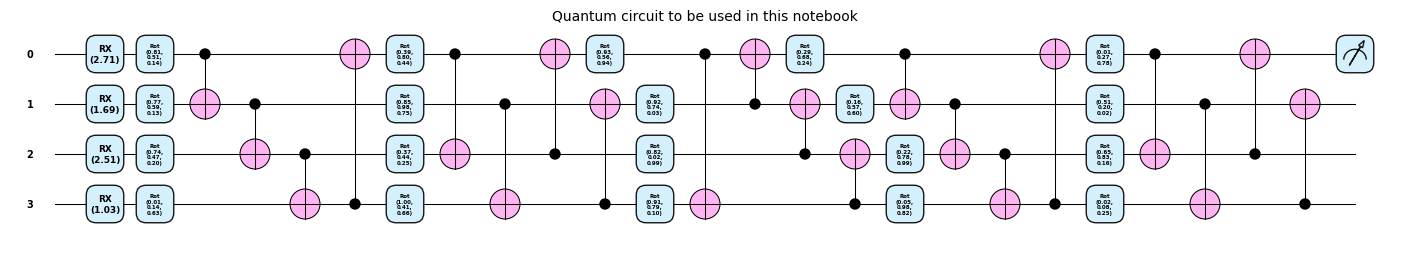

In [23]:
### Draw the test model circuit
draw_circuit(test.qmodel_qc(), scale=0.5, title='Quantum circuit to be used in this notebook', level='device') \
    (X_train_tens[0], weights) # level='device'/'gradient'

In [24]:
### Test if the model works as a function
test(X_train_tens[0:5])

tensor([[-0.0540],
        [ 0.1780],
        [ 0.0880],
        [ 0.3020],
        [ 0.2040]], dtype=torch.float64, grad_fn=<ViewBackward0>)

### Creation and training of the actual PennyLane/PyTorch model

In [25]:
### Trains the classical AE model

def train_quantum(model, X, y, cost_fun, acc_fun, optimizer, epochs, 
                  log_interv=100, prompt_fract=0.1, acc_prec=0.3, start_time=0):
    # global history, acc_hist, opt_params, hist_params
    
    history = []
    acc_hist = []
    opt_params = {}
    hist_params = []
    min_epoch = 0
    min_cost = 1000
    min_acc = 1000
    if start_time == 0: start_time = time.time()
    
    model.train()
    for epoch in range(epochs):
        
        optimizer.zero_grad()
        output = model(X)
        cost = cost_fun(output, y)
        acc = acc_fun(output, y, prec=acc_prec)
        cost.backward()
        optimizer.step()

        curr_loss = cost.item()
        curr_acc = acc
        if curr_loss < min_cost: 
            min_cost = curr_loss
            min_epoch = epoch
            opt_params = copy.deepcopy(model.state_dict())

        if curr_acc < min_acc:
            min_acc = curr_acc

        if epoch % log_interv == 0:
            history.append(curr_loss)
            acc_hist.append(curr_acc)
            hist_params.append(copy.deepcopy(model.state_dict()))

        elapsed = time.time() - start_time
        if (prompt_fract == 0) or (epoch % int(prompt_fract*epochs) == 0):
            print(f'{epoch: 5d} '+ \
                  f'({elapsed:06.0f} sec): '+ \
                  f'Loss {curr_loss:6.4g}   '+ \
                  f'Acc {curr_acc:6.4g}')
            
    return history, acc_hist, opt_params, hist_params, (min_epoch, min_cost)


In [26]:
### Set up the training run
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Create a model
q_auto = Quantum_Auto(sim, X_train_tens.shape[1], n_layers=n_layers, shots=shots, scaler=scaler).double().to(torch_device)

### Loss and optimiser

# cost_fun = nn.L1Loss() # Very poor results
cost_fun = nn.MSELoss()

# opt = optim.SGD(model.parameters(),lr=0.01,weight_decay=1e-5)
# opt = torch.optim.Adam(q_auto.parameters())
opt = torch.optim.NAdam(q_auto.parameters(), lr=0.01)

In [27]:
### Train the model

start_time = time.time()

train_mse_hist, train_acc_hist, opt_params, hist_params, opt_point = \
    train_quantum(q_auto, X_train_tens, y_train_tens, cost_fun, accuracy, opt, epochs, 
                  log_interv=log_interv, prompt_fract=prompt_fract, acc_prec=acc_prec)

elapsed = time.time() - start_time

    0 (000007 sec): Loss  1.119   Acc 0.4015
    4 (000035 sec): Loss 0.8178   Acc 0.4672
    8 (000064 sec): Loss 0.6172   Acc 0.4672
   12 (000093 sec): Loss 0.4735   Acc 0.4672
   16 (000121 sec): Loss 0.3853   Acc 0.4672
   20 (000150 sec): Loss 0.3202   Acc 0.4672
   24 (000179 sec): Loss 0.2801   Acc 0.4672
   28 (000207 sec): Loss 0.2428   Acc  0.562
   32 (000236 sec): Loss 0.2122   Acc 0.6642
   36 (000265 sec): Loss 0.1918   Acc  0.781
   40 (000293 sec): Loss 0.1779   Acc 0.8248
   44 (000322 sec): Loss 0.1654   Acc 0.8175
   48 (000350 sec): Loss 0.1563   Acc 0.8394
   52 (000378 sec): Loss 0.1516   Acc 0.8248
   56 (000407 sec): Loss 0.1463   Acc 0.8321
   60 (000435 sec): Loss 0.1414   Acc 0.8321
   64 (000464 sec): Loss 0.1376   Acc 0.8175
   68 (000492 sec): Loss 0.1343   Acc 0.8321
   72 (000521 sec): Loss 0.1369   Acc 0.8175
   76 (000549 sec): Loss 0.1325   Acc 0.8394


### Calculate optimum scores

In [28]:
### Accumulate test scores
test_mse_hist = []
test_acc_hist = []

### Find training loss and accuracy
train_min_mse = nnp.min(train_mse_hist)
train_min_mse_iter = nnp.argmin(train_mse_hist)
train_max_acc = nnp.max(train_acc_hist)
train_max_acc_iter = nnp.argmax(train_acc_hist)

### Initialise testing loss and accuracy
test_min_mse = 1000
test_min_mse_iter = -1
test_max_acc = 0
test_max_acc_iter = -1

### Calculate testing loss and accuracy
for iter in range(len(hist_params)):
    q_auto.load_state_dict(hist_params[iter])
    test_pred = q_auto(X_test_tens)
    curr_acc = accuracy(test_pred, y_test_tens, prec=acc_prec)
    curr_loss = square_loss(test_pred, y_test_tens)
    test_acc_hist.append(curr_acc)
    test_mse_hist.append(curr_loss)
    if curr_acc > test_max_acc:
        test_max_acc = curr_acc
        test_max_acc_iter = iter
    if curr_loss < test_min_mse:
        test_min_mse = curr_loss
        test_min_mse_iter = iter

In [29]:
# Print run statistics
shape = q_auto.qshape()
n_weights = np.prod(shape)
time_str = time.strftime("%H:%M:%S", time.gmtime(elapsed))

print(f'\n'+
      f'Run Summary:\t'+
      f'devices = {torch_device} + {sim}\n\t\t'+
      f'samples = {y_train_tens.shape[0]}, '+
      f'features = {X_train_tens.shape[1]}, '+
      f'params = {count_params(q_auto)}, '+
      f'epochs = {epochs}\n\t\t'+
      f'training: cost = {round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'acc = {round(train_max_acc, 5):05.4f} @ {train_max_acc_iter:04d}\n\t\t'+
      f'testing:  cost = {round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'acc = {round(test_max_acc, 5):05.4f} @ {test_max_acc_iter:04d}\n\t\t'+
      f'elapsed time = {elapsed:0.0f}sec ({time_str})'+
      f'\n'
     )


Run Summary:	devices = cpu + lightning.qubit
		samples = 137, features = 4, params = 60, epochs = 80
		training: cost = 0.1295 @ 0078, acc = 0.8467 @ 0050
		testing:  cost = 0.1203 @ 0075, acc = 0.8971 @ 0062
		elapsed time = 570sec (00:09:30)



### Plot costs and scores

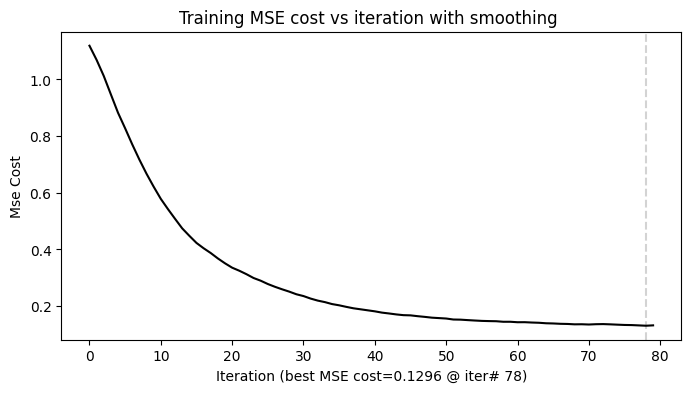

In [30]:
### Plot training cost
meas_plot(train_mse_hist, meas='MSE cost', task='min', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.5,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtrain_mse.eps")}')

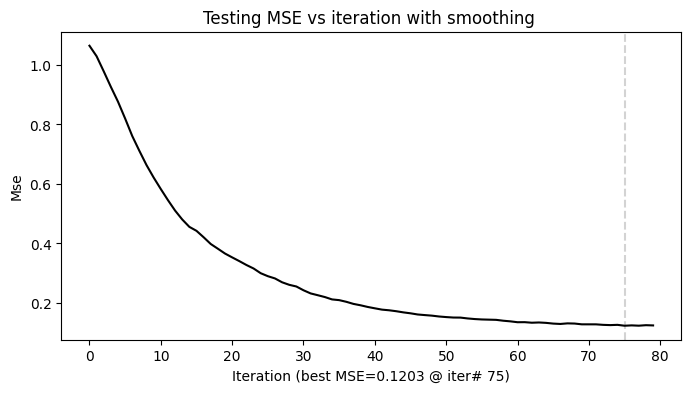

In [31]:
### Plot test cost
meas_plot(test_mse_hist, meas='MSE', task='min', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv,
                  backplot=False, back_color='linen', smooth_weight=0.5,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtest_mse.eps")}')

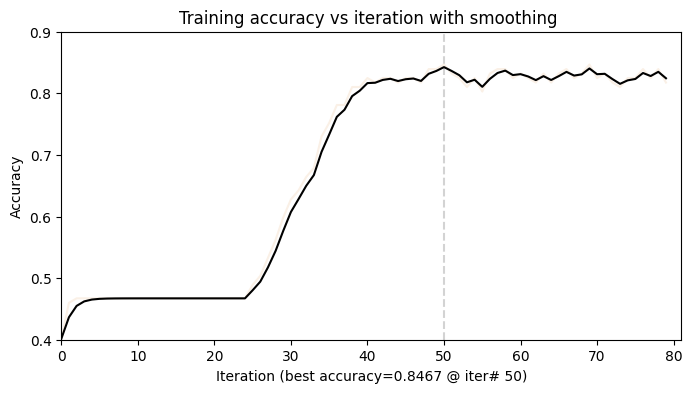

In [32]:
### Plot training accuracy
meas_plot(train_acc_hist, meas='accuracy', task='max', title_pref='Training',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), ylim=(0.4, 0.9),
                  backplot=True, back_color='linen', smooth_weight=0.4,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtrain_acc.eps")}')

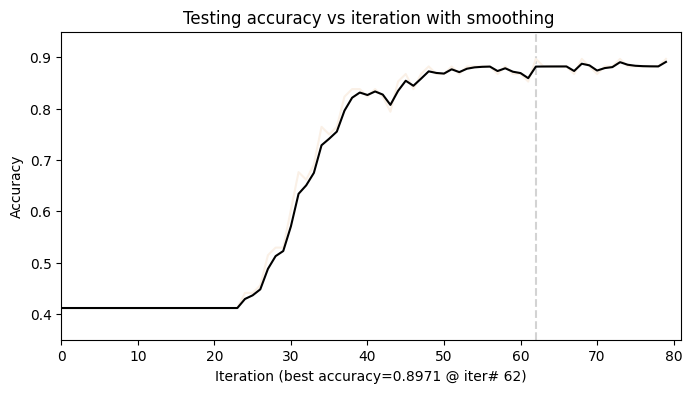

In [33]:
### Plot testing accuracy
meas_plot(test_acc_hist, meas='accuracy', task='max', title_pref='Testing',
                  rcParams=(8, 4), log_interv=log_interv, xlim=(0, epochs+1), ylim=(0.35, 0.95),
                  backplot=True, back_color='linen', smooth_weight=0.4,
                  save_plot=f'{os.path.join(PLOTS_PATH, f"{RSRC_NAME}_qtest_acc.eps")}')

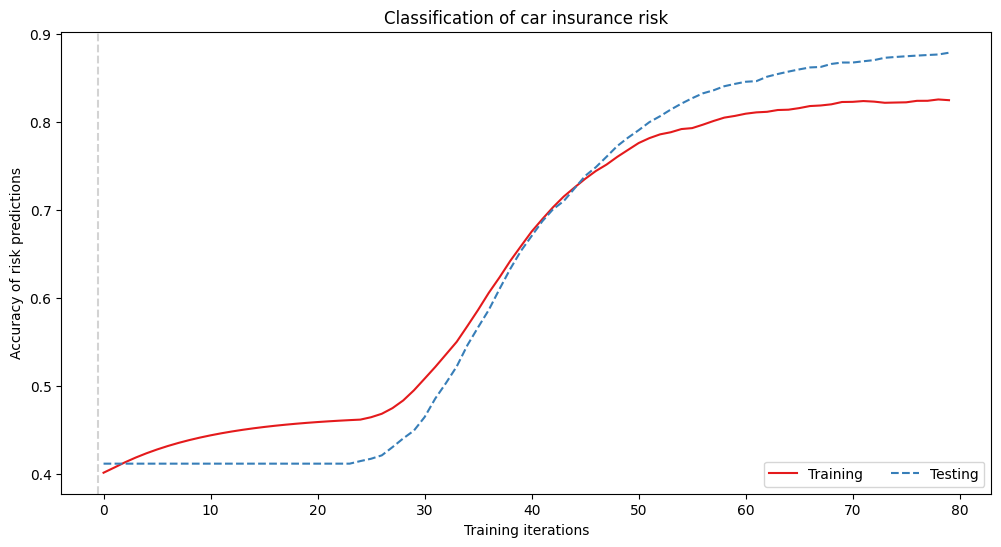

In [34]:
multi_plot_series(
    [train_acc_hist, test_acc_hist], X_list=[0, 0], labels=['Training', 'Testing'], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='Accuracy of risk predictions',
    legend_cols=2, smooth_weight=0.9, title='Classification of car insurance risk')

## What's next?
*At this point you can improve this notebook by performing the following tasks:*

- Save the history of loss and accuracy into a resource folder
- Save all model parameters kept during the model training into a resource folder
- Play with the smoothing factor in all plots to gain insight into volatility of your scores
- Analyse all accumulated data and report your observations, reflect on your learning

*As an extension:*

- Prepare an Automobile data set, a model and its scores, to predict car price (exclude symboling which is a variable dependent on price)
- Repeat the entire process for the "sonar" data set (link included above)
- Enjoy learning predictive analytics using classical and quantum ML models

## Modifications (do not remove)
Under the [Creative Commons CC-BY](https://creativecommons.org/licenses/by/4.0/) license, if you perform any changes to this notebook, please list them here, adding a note with your name, contact details, date and changes to the code.

- [Jacob Cybulski](http://jacobcybulski.com) (2024, 1 Oct): The author of this notebook added this section to record all code changes
- [Jacob Cybulski](http://jacobcybulski.com) (2025, 3 Mar): Compatibility update to PennyLane v0.40.0 and PyTorch v2.6.0

## Systems in use

In [35]:
!pip list | grep -e PennyLane -e torch

PennyLane                 0.40.0
PennyLane_Lightning       0.40.0
torch                     2.6.0+cpu
torchaudio                2.6.0+cpu
torchsummary              1.5.1
torchvision               0.21.0+cpu

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
